In [1]:
import os
import librosa
import random
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import tqdm as tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import minmax_scale
import lightning as L
import torchmetrics

In [2]:
import torch
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
#dataset
class Audio_dataset(Dataset):
    def __init__(self, dir_path, dataset_sampling_rate, anomaly_dir_path):
        # self.dataset_sampling_rate = 22050
        self.ANOMALY_POWER = 1
        self.dir_path = dir_path
        self.anomaly_dir_path = anomaly_dir_path
        self.dataset_sampling_rate = dataset_sampling_rate
        self.file_names = os.listdir(self.dir_path)
        if 'desktop.ini' in self.file_names:
            self.file_names.remove('desktop.ini')
        self.last_idx = len(self.file_names)
        self.anomaly_recorded_path_dir = self.anomaly_dir_path
        self.anomaly_recorded_file_names = os.listdir(self.anomaly_recorded_path_dir)
        if 'desktop.ini' in  self.anomaly_recorded_file_names:
             self.anomaly_recorded_file_names.remove('desktop.ini')
        self.anomaly_speech_path_dir =  self.dir_path
        self.anomaly_speech_file_names = os.listdir(self.anomaly_speech_path_dir)
        if 'desktop.ini' in  self.anomaly_speech_file_names:
             self.anomaly_speech_file_names.remove('desktop.ini')
   
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        data, sr, cqt_1 = self.pipeline(idx)
        _, _, cqt_2 = self.pipeline(random.randint(0, self.last_idx - 1), anomaly=True)
        _, _, anchor = self.pipeline(random.randint(0, self.last_idx - 1))
        return anchor, cqt_1, cqt_2, data, sr

    def pipeline(self, id, anomaly=False):
        data, sr = self.load_data(id)
        data = self.cut_silence(data)
        data = self.augment_audio(data, sr)
        data = self.cut_data(data)
        if anomaly:
            data = self.add_anomaly(data, sr)
        cqt  = self.make_cqt(data)
        cqt = np.abs((cqt+80)/80)
        cqt = cqt.reshape((1, cqt.shape[0], cqt.shape[1]))
        return data, sr, cqt
    
    def load_data(self,id):
        file_path = os.path.join(self.dir_path, self.file_names[id])
        data, sr = librosa.load(file_path, sr=self.dataset_sampling_rate)
        return data, sr

    def cut_silence(self, data):
        data_intervals = librosa.effects.split(y=data,frame_length=512, hop_length=128, top_db=48)
        data = np.concatenate([data[s[0]:s[1]] for s in data_intervals])
        return data

    def augment_audio(self, data, sr):
        steps = (random.random() * 4) - 2
        stretch = 1 - (random.random() * 0.2)
        data = librosa.effects.time_stretch(data, rate=stretch)
        data = librosa.effects.pitch_shift(data, sr=sr, n_steps=steps)
        return data

    def cut_data(self, data):
        # the last possible element to slice
        end_point = len(data) - self.dataset_sampling_rate
        # choose first elemnt 
        start_point = random.randint(0, end_point)
        # slice 1s of data
        data = data[start_point:start_point + self.dataset_sampling_rate]
        return data

    def make_cqt(self, data):
        C = librosa.cqt(data, sr=self.dataset_sampling_rate)
        cqt = librosa.power_to_db(np.abs(C)**2)
        cqt = np.array(cqt, dtype='float32')
        return cqt
    
    def augment_cqt(self,data):
        flip = random.random()
        if flip > 0.8:
            data = np.flip(data,axis=1)
        return data
    
    def add_anomaly(self, data, sr):
        anomaly_type = random.randint(0,1)
        if anomaly_type == 0:
            anomaly_recorded_id = random.randint(0, len(self.anomaly_recorded_file_names)-1)
            anomaly_file_path = os.path.join(self.anomaly_recorded_path_dir, self.anomaly_recorded_file_names[anomaly_recorded_id])
            anomaly_file_data_raw, _ = librosa.load(anomaly_file_path, sr=sr)
            max_starting_sample = len(data) - len(anomaly_file_data_raw)
            start = random.randint(0, max_starting_sample-1)
            for i in range(len(anomaly_file_data_raw)):
                data[start] += anomaly_file_data_raw[i]
                start += 1
        elif anomaly_type == 1:
            anomaly_recorded_id = random.randint(0, len(self.anomaly_speech_file_names)-1)
            anomaly_file_path = os.path.join(self.anomaly_speech_path_dir, self.anomaly_speech_file_names[anomaly_recorded_id])
            anomaly_file_data_raw, _ = librosa.load(anomaly_file_path, sr=sr)
            anomaly_data_intervals = librosa.effects.split(y=anomaly_file_data_raw,frame_length=512, hop_length=128, top_db=48)
            anomaly_data = np.concatenate([anomaly_file_data_raw[s[0]:s[1]] for s in anomaly_data_intervals])

            anomaly_start_sample = random.randint(0, int(sr/2)-1)
            anomaly_length = random.randint(int(sr/4), int(sr/2)-1)
            anomaly_data = anomaly_data[anomaly_start_sample: anomaly_start_sample + anomaly_length]

            max_starting_sample = len(data) - len(anomaly_data)
            start = random.randint(0, max_starting_sample-1)
            for i in range(len(anomaly_data)):
                anomaly_data[i] /= 2
                anomaly_data[i] *= self.ANOMALY_POWER
                data[start] += anomaly_data[i]
                start += 1
                
        
        return data

In [4]:
#model
class Audio_conv(nn.Module):
    def __init__(self, margin, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 'same')
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 'same')
        self.conv3 = nn.Conv2d(64, 64, 5, 1, 'same')
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 'same')
        
        self.self_attn = nn.MultiheadAttention(128, 16, batch_first=True)

        self.fc1 = nn.Linear(6400, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 6)

        self.margin = margin

    def forward(self,x):
        #conv
        x_conv  = self.conv1(x)
        x_conv  = F.leaky_relu(x_conv)
        x_conv  = self.pool(x_conv )

        x_conv  = self.conv2(x_conv )
        x_conv  = F.leaky_relu(x_conv )
        x_conv  = self.pool(x_conv )

        x_conv  = self.conv3(x_conv )
        x_conv  = F.leaky_relu(x_conv )

        x_conv  = self.conv4(x_conv )
        x_conv  = F.leaky_relu(x_conv )
        x_conv  = self.pool(x_conv )

        #attention
        x_conv  = x_conv.permute(0, 2, 3, 1)
        batch_size, height, width, feature_dim = x_conv.size()
        x_conv = x_conv.reshape(batch_size, height * width, feature_dim)
        attn_output, _ = self.self_attn(x_conv, x_conv, x_conv)
        attn_output = attn_output.reshape(batch_size, height, width, feature_dim)
        attn_output = attn_output.permute(0, 3, 1, 2)

        #fully connected
        x_fc = torch.flatten(attn_output, 1)
        x_fc = self.fc1(x_fc)
        x_fc  = F.relu(x_fc) 
        x_fc = self.fc2(x_fc)
        x_fc  = F.relu(x_fc)
        x_fc = self.fc3(x_fc)
        x_fc  = F.relu(x_fc)
        x_fc = self.fc4(x_fc)

        return x_fc

In [5]:
class Lit_wrapper(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.TripletMarginLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x1, x2, x3, _, _ = batch
        output1 = self.model(x1)
        output2 = self.model(x2)
        output3 = self.model(x3)
        loss = self.loss_fn(output1,output2,output3)
        self.log("train_loss", loss)
        return loss
    
    def on_test_start(self):
         self.test_step_outputs = []

    def test_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        _, x1, x2, _, _ = batch
        output1 = self.model(x1)
        output2 = self.model(x2)
        self.test_step_outputs.append(output1)
        self.test_step_outputs.append(output2)
    
    def on_test_end(self):
        self.test_outputs = torch.stack(self.test_step_outputs)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x1, x2, x3, _, _ = batch
        output1 = self.model(x1)
        output2 = self.model(x2)
        output3 = self.model(x3)
        loss = self.loss_fn(output1,output2,output3)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def loss_func(self, output1, output2):
        loss, pos_accu, neg_accu= 0, 0, 0
        size = len(output1)
        for i in range(0, size, 2):
            pos_dis = output1[i] - output1[i+1]
            pos = torch.linalg.vector_norm(pos_dis)
            pos_accu += pos
            neg_dis = output2[i] - output2[i+1]
            neg = torch.linalg.vector_norm(neg_dis)
            neg_accu += neg
            partial_losses = pos + np.maximum(0, self.model.margin - neg.item())
            loss += torch.mean(partial_losses)
        return loss, pos_accu, neg_accu
    
    def loss_func_euclidean(self, output1, output2):
        loss, pos_accu, neg_accu= 0, 0, 0
        size = len(output1)
        for i in range(0, size, 2):
            pos_dis = F.pairwise_distance(output1[i], output1[i+1])
            neg_dis = F.pairwise_distance(output2[i], output2[i+1])
            loss += pos_dis + np.maximum(0, self.model.margin - neg_dis.item())
            pos_accu += pos_dis
            neg_accu += neg_dis
        return loss, pos_accu, neg_accu

In [ ]:
#setup
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath='models/top',
    filename='{epoch}-{val_loss:.2f}-',
    monitor='val_loss',
    save_top_k = 1
)

early_stopping_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss',
    mode='min'
)


#train
dir_path = r"..\datasets\kaggle\Merged"
anomaly_path = r"..\datasets\anomalies\nagrane"
sr = 22050
train = Audio_dataset(dir_path, sr, anomaly_dir_path=anomaly_path)
train_dataloader = DataLoader(train, batch_size=4, shuffle=True)

#val and test
dir_path = r"..\datasets\kaggle\merged_2_speakers_test"
anomaly_path = r"..\datasets\anomalies\nagrane_test"
sr = 22050
test_dataset = Audio_dataset(dir_path, sr, anomaly_dir_path=anomaly_path)
val_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#debug
test, debug = torch.utils.data.random_split(test_dataset, [0.99, 0.01])
debug_dataloader = DataLoader(debug, batch_size=1, shuffle=False)


trainer = L.Trainer(
    max_epochs=30, 
    # gradient_clip_val=1, 
    callbacks=[checkpoint_callback, early_stopping_callback],
    # check_val_every_n_epoch=1
    )

In [7]:
audio_conv = Audio_conv(margin=1)
model = Lit_wrapper(audio_conv)

In [ ]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
trainer.test(model, dataloaders=test_dataloader)

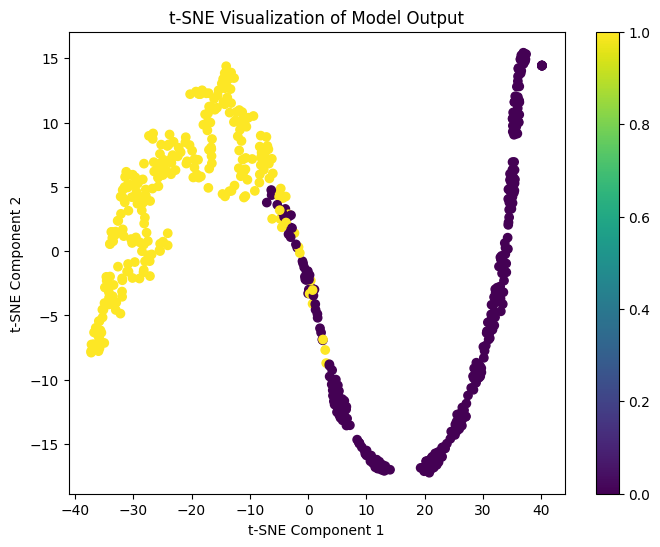

In [11]:
from sklearn.manifold import TSNE
output = model.test_outputs.cpu()
output = torch.squeeze(output)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
components = tsne.fit_transform(output)

labels = np.zeros(len(output))
for i in range(len(output)):
    if i % 2 == 0:
        labels[i] = 1
    else:
        labels[i] = 0
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], cmap='viridis', c=labels)
plt.colorbar()
plt.title('t-SNE Visualization of Model Output')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [12]:
class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.fc = nn.Linear(6, 2)
        
    def forward(self, x):
        x_backbone= self.model(x)
        x = self.fc(x_backbone)
        x = F.sigmoid(x)
        return x, x_backbone

In [13]:
class Detector_wrapper(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.MSELoss()
        self.score = []
        self.f1 = torchmetrics.F1Score(task='multiclass', num_classes=2)

    def on_train_start(self):
        self.tensors_train = []
        self.labels_train = []
        
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        _, x1, x2, _, _ = batch
        xs = []
        labels = []
        for i in range(len(x1)):
            is_anomaly = random.randint(0,1)
            if is_anomaly == 0:
                x = x1[i]
                label = torch.Tensor([1,0])
            elif is_anomaly == 1:
                x = x2[i]
                label = torch.Tensor([0,1])
            xs.append(x)
            labels.append(label)
        x = torch.stack(xs)
        label = torch.stack(labels).to('cuda:0')
        output, backbone = self.model(x)
        self.tensors_train.append(backbone)
        self.labels_train.append(label)
        loss = self.loss_fn(output, label)
        self.log("train_detector_loss", loss)
        return loss
    
    def on_train_end(self):
        self.train_tensors_end = torch.stack((self.tensors_train))
        self.train_labels_end = torch.stack((self.labels_train))

    def train_step_debug(self,batch):
        x1, x2 = batch
        xs = []
        labels = []
        for i in range(len(x1)):
            is_anomaly = random.randint(0,1)
            if is_anomaly == 0:
                x = x1[i]
                label = torch.Tensor([1,0])
            elif is_anomaly == 1:
                x = x2[i]
                label = torch.Tensor([0,1])
            xs.append(x)
            labels.append(label)
        x = torch.stack(xs)
        label = torch.stack(labels).to('cuda:0')
        output, backbone = self.model(x)
        return backbone

    def on_test_start(self):
         self.score = []
         self.outputs_tensors = []
         self.outputs_target = []
         self.outputs_preds = []
    
    def test_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        _, x1, x2, _, _ = batch
        xs = []
        labels = []
        for i in range(len(x1)):
            if random.randint(0,1) == 0:
                x = x1[i]
                label = torch.Tensor([1,0])
            else:
                x = x2[i]
                label = torch.Tensor([0,1])
            xs.append(x)
            labels.append(label)
        x = torch.stack(xs)
        label = torch.stack(labels).to('cuda:0')
        output, _ = self.model(x)
        preds = torch.argmax(output,dim=1)
        target = torch.argmax(label,dim=1)
        score = self.f1(preds, target)
        self.score.append(score)
        self.outputs_tensors.append(output)
        self.outputs_preds.append(preds)
        self.outputs_target.append(target)

    def on_test_end(self):
        self.test_outputs = torch.stack(self.score)
        self.test_outputs_tensors = torch.stack(self.outputs_tensors)
        self.outputs_preds = torch.stack(self.outputs_preds)
        self.outputs_target = torch.stack(self.outputs_target)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        _, x1, x2, _, _ = batch
        xs = []
        labels = []
        for i in range(len(x1)):
            is_anomaly = random.randint(0,1)
            if is_anomaly == 0:
                x = x1[i]
                label = torch.Tensor([1,0])
            elif is_anomaly == 1:
                x = x2[i]
                label = torch.Tensor([0,1])
            xs.append(x)
            labels.append(label)
        x = torch.stack(xs)
        label = torch.stack(labels).to('cuda:0')
        output, backbone = self.model(x)
        loss = self.loss_fn(output, label)
        self.log("val_detector_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [14]:
detector = Detector(audio_conv)

# train last layer
layers_count = 0
for param in detector.parameters():
    layers_count += 1

for i, param in enumerate(detector.parameters()):
    if layers_count - i != 1 and layers_count - i != 2:
        param.requires_grad = False

anomaly_detector = Detector_wrapper(detector)

In [15]:
early_stopping_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(
    monitor='val_detector_loss',
    mode='min'
)

trainer_detector = L.Trainer(
    max_epochs=10,
    # callbacks=[early_stopping_callback]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer_detector.fit(anomaly_detector, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
trainer_detector.test(anomaly_detector, test_dataloader)
f1 = torch.mean(anomaly_detector.test_outputs).item()
print('f1 = ', f1*100, '%')

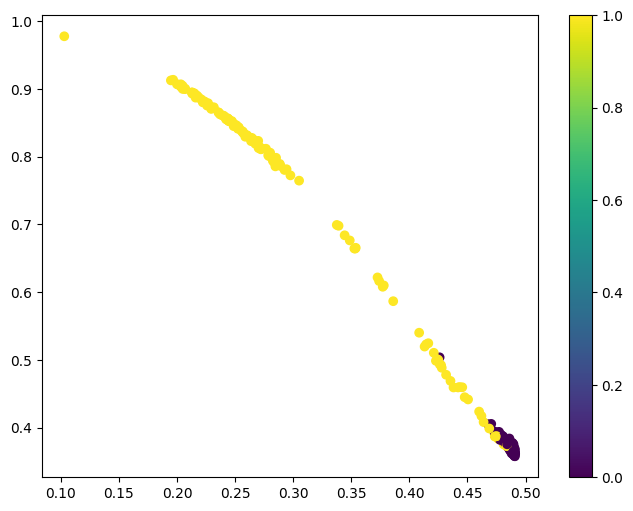

In [19]:
output = anomaly_detector.test_outputs_tensors
output = torch.squeeze(output)
output = output.cpu().numpy()
labels = anomaly_detector.outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()
plt.figure(figsize=(8, 6))
plt.scatter(output[:, 0], output[:, 1], cmap='viridis', c=labels)
plt.colorbar()
plt.show()

In [20]:
torch.save(model, 'base.pt')